## Plan of work <a id = "plan"> </a>

[1. Downloading and preparing data](#1.)<br>
[2. Train models](#2.)<br>
[2.1. Logistic regression](#2.1.)<br>
[2.2. Catboost](#2.2.)<br>
[3. Final testing](#3.)<br>
[3.1. Logistic regression](#3.1.)<br>
[3.2. Catboost](#3.2.)<br>

In [115]:
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

# 1. Downloading and preparing data <a id = "1."> </a>

[Back to plan](#plan)

In [116]:
df = pd.read_csv("./Data/train.csv")

In [117]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, stratify=df["target"], test_size=0.2, random_state=42, shuffle=True)

In [118]:
#  The Function for text preprocessing
def tokenize_string(text):

    # Before lemmatizing replace all constructions with normal words
#     text_upd = contractions.fix(text)

    # Tokenize the data and use only lower letters
    words = word_tokenize(text.lower())
    
    # Create a lemmatizer object
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos = "v") for word in words] 
    
    # # Get rid of punctuation
    words = [word for word in lemmas if word not in string.punctuation]
    
    # Remove stop words
    # Stop words corpus (179 in total)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return words

In [119]:
# Tokenizing the series for train data
print('I have just started updatind train_df')
train_df['Preprocessed_text'] = train_df.question_text.apply(tokenize_string)

# Tokenizing the series for test data
print('I have just started updatind test_df')
test_df['Preprocessed_text'] = test_df.question_text.apply(tokenize_string)

I have just started updatind train_df
I have just started updatind test_df


In [120]:
y_train = train_df.target.values
y_test = test_df.target.values

In [121]:
train_df['Preprocessed_text'].head()

1084609                                 [best, career, 12th]
706705     [role, think, human, life, show, person, life,...
1045271    [strange, time, happy, alone, walk, outside, t...
249178            [magic, real, allow, people, teach, learn]
743750     [effective, cognitive, behavioral, therapy, de...
Name: Preprocessed_text, dtype: object

In [122]:
word2vec_model = Word2Vec(
    train_df['Preprocessed_text'], 
    vector_size=300, 
    window=5, 
    min_count=3
)

In [123]:
# Function for preprocessing the whole phrase instead of separate phrases
def phrase_vector(word2vec_model, phrase):
    phrase = [word for word in phrase if word in word2vec_model.wv.key_to_index]
    
    if len(phrase) == 0:
        return np.zeros(word2vec_model.vector_size)
    
    return np.mean(word2vec_model.wv[phrase], axis=0)

In [124]:
# Applying the function
X_train_vec = np.array([phrase_vector(word2vec_model, phrase) for phrase in train_df['Preprocessed_text']])
X_test_vec = np.array([phrase_vector(word2vec_model, phrase) for phrase in test_df['Preprocessed_text']])

# 2. Train models <a id = "2."> </a>

[Back to plan](#plan)

## 2.1. Logistic regression <a id = "2.1."> </a>

[Back to plan](#plan)

In [132]:
# Train a logistic regression model on the vectorized data
model_logreg = LogisticRegression(
    random_state=42, 
    solver='liblinear',
)
model_logreg.fit(X_train_vec, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [133]:
# Make a prediction on new data
y_pred_logreg = model_logreg.predict(X_test_vec)

## 2.2. Catboost <a id = "2.2."> </a>

[Back to plan](#plan)

In [134]:
model_ctb = CatBoostClassifier(
    iterations=10000, 
    learning_rate=0.1, 
    depth=6, 
    loss_function='CrossEntropy', 
    random_seed=42,
)
model_ctb.fit(X_train_vec, y_train, verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5438389	total: 354ms	remaining: 59m 1s
10:	learn: 0.1798692	total: 3.56s	remaining: 53m 48s
20:	learn: 0.1519178	total: 6.81s	remaining: 53m 54s
30:	learn: 0.1448937	total: 9.94s	remaining: 53m 15s
40:	learn: 0.1415673	total: 12.9s	remaining: 52m 12s
50:	learn: 0.1394094	total: 15.7s	remaining: 51m 9s
60:	learn: 0.1378482	total: 18.8s	remaining: 50m 55s
70:	learn: 0.1366254	total: 21.4s	remaining: 49m 55s
80:	learn: 0.1356087	total: 24.3s	remaining: 49m 37s
90:	learn: 0.1347163	total: 27.3s	remaining: 49m 29s
100:	learn: 0.1339612	total: 30.3s	remaining: 49m 31s
110:	learn: 0.1333253	total: 33.1s	remaining: 49m 9s
120:	learn: 0.1327473	total: 36s	remaining: 49m
130:	learn: 0.1321955	total: 38.9s	remaining: 48m 48s
140:	learn: 0.1317052	total: 41.8s	remaining: 48m 41s
150:	learn: 0.1311499	total: 44.6s	remaining: 48m 32s
160:	learn: 0.1307099	total: 47.5s	remaining: 48m 24s
170:	learn: 0.1302768	total: 50.5s	remaining: 48m 23s
180:	learn: 0.1298445	total: 53.4s	remaining: 48

In [135]:
y_pred_ctb = model_ctb.predict(X_test_vec)

# 3. Final testing <a id = "3."> </a>

[Back to plan](#plan)

In [136]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def conf_matrix(target, predicted):
    cm = confusion_matrix(y_target=target, 
                          y_predicted=predicted)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10, 10), 
                                    show_absolute=True, show_normed=True, colorbar=True)
    plt.show()

def eval_predictions(model, features_train, target_train, features_valid, target_valid):
    '''
    Функция принимает в качестве аргументов: модель, признаки и целевой признак выборки для обучения и тестирования.
    Функция обучает заданную модель по обучающей выборке и расчитывает метрики по тестовой выборке: F1-меру, коэффициент Мэтьюса.
    '''
    predictions = model.predict(features_valid)
    print('F1-мера для класса (1): {:.2f}'. format(f1_score(target_valid, predictions)))
    print('Коэффициент Мэтьюса: {:.2f}'. format(matthews_corrcoef(target_valid, predictions)))
    print('Accuracy: {:.2f}'. format(accuracy_score(target_valid, predictions)))
    print('Balanced accuracy: {:.2f}'. format(balanced_accuracy_score(target_valid, predictions)))
    print(classification_report(target_valid, predictions, labels=[0,1]))
    roc(model, features_valid, target_valid)
    conf_matrix(target_valid, predictions)
    return model

def roc(model, features_valid, target_valid):
    '''
    Функция принимает в качестве аргументов: модель, признаки и целевой признак для тестирования.
    Функция строит ROC-кривую модели, ROC-кривую случайной модели модели и высчитывает AUC-ROC.
    '''
    #расчитываем fpr и tpr
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_one_valid)
    fig, ax = plt.subplots(1, 2, figsize = (15,10))
    
    # ROC-кривая нашей модели
    ax[0].plot(fpr, tpr, linestyle='-')
    # ROC-кривая случайной модели
    ax[0].plot([0, 1], [0, 1], linestyle='--')
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,1)
    ax[0].set_xlabel('False Positive Rate') 
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC-кривая')
    
    # PR-кривая нашей модели
    ax[1].plot(recall, precision)
    ax[1].set_xlim(0,1)
    ax[1].set_ylim(0,1)
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('PR-кривая')
    
    plt.show()
    # вычисляем AUROC
    print('AUROC: {:.2f}'.format(roc_auc_score(target_valid, probabilities_one_valid)))
    # вычисляем AUPRC
    print ('AUPRC: {:.2f}'.format(average_precision_score(target_valid, probabilities_one_valid)))

## 3.1. Logistic regression <a id = "3.1."> </a>

[Back to plan](#plan)

F1-мера для класса (1): 0.31
Коэффициент Мэтьюса: 0.33
Accuracy: 0.94
Balanced accuracy: 0.60
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    245063
           1       0.57      0.22      0.31     16162

    accuracy                           0.94    261225
   macro avg       0.76      0.60      0.64    261225
weighted avg       0.93      0.94      0.93    261225



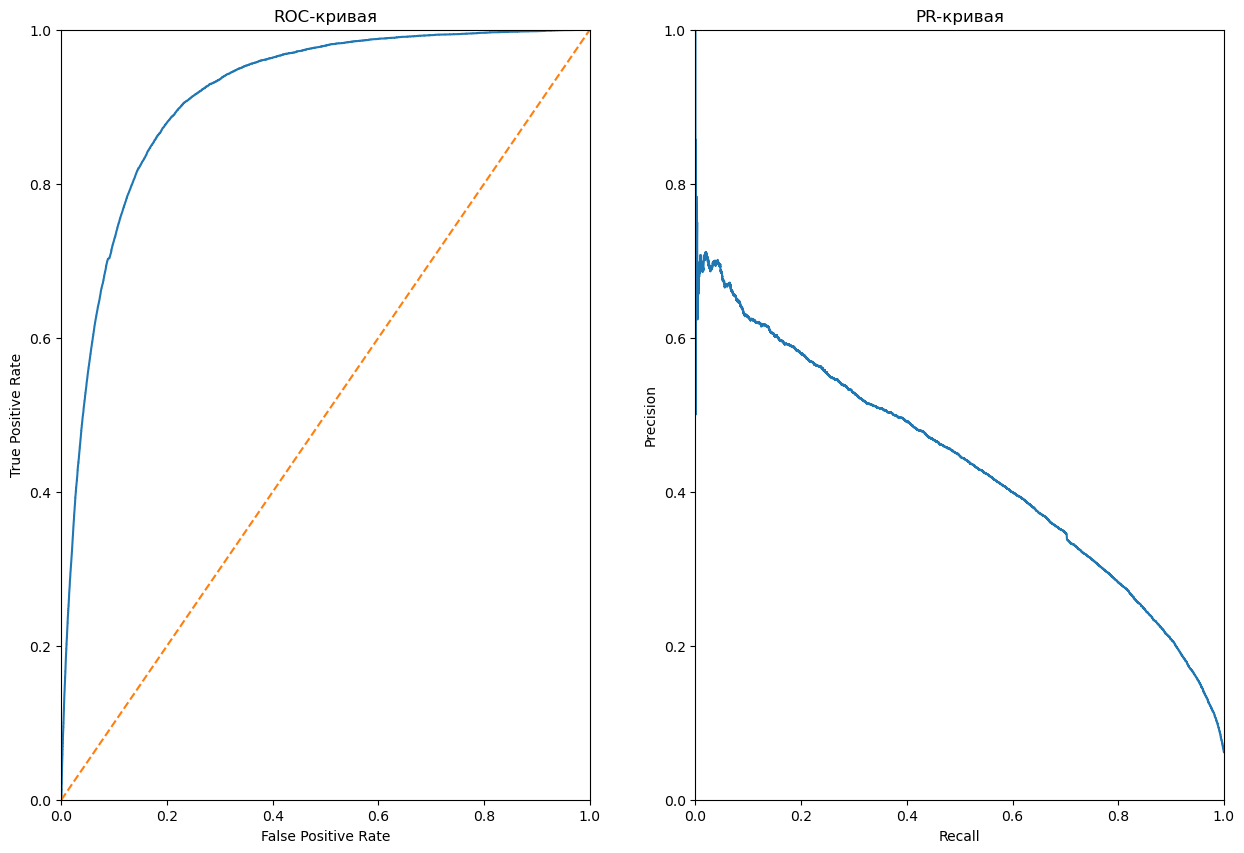

AUROC: 0.91
AUPRC: 0.43


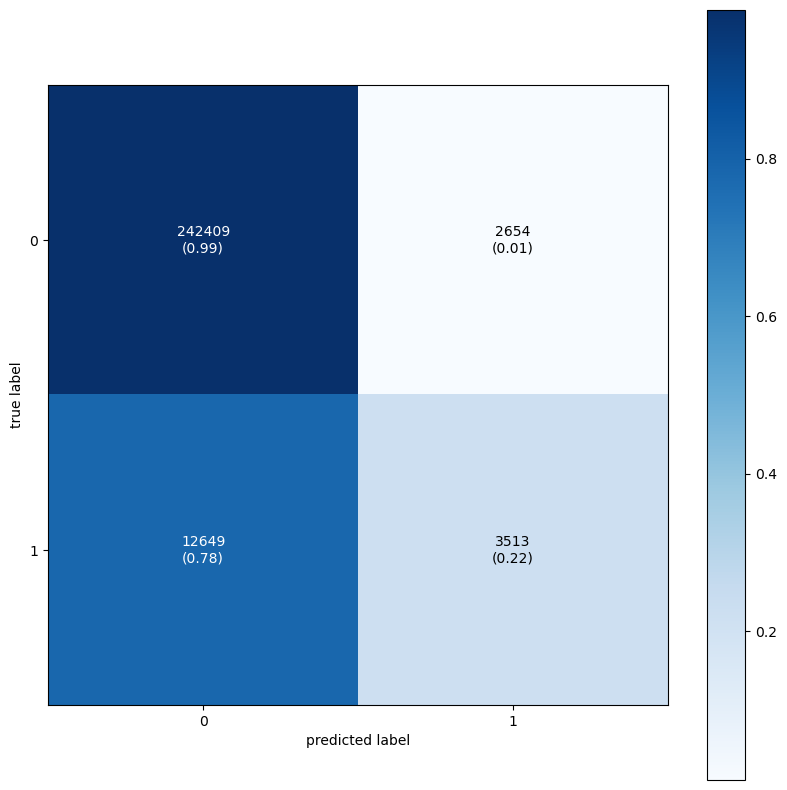

LogisticRegression(random_state=42, solver='liblinear')

In [137]:
eval_predictions(model_logreg, X_train_vec, y_train, X_test_vec, y_test)

## 3.2. Catboost <a id = "3.2."> </a>

[Back to plan](#plan)

F1-мера для класса (1): 0.54
Коэффициент Мэтьюса: 0.53
Accuracy: 0.95
Balanced accuracy: 0.72
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    245063
           1       0.68      0.45      0.54     16162

    accuracy                           0.95    261225
   macro avg       0.82      0.72      0.76    261225
weighted avg       0.95      0.95      0.95    261225



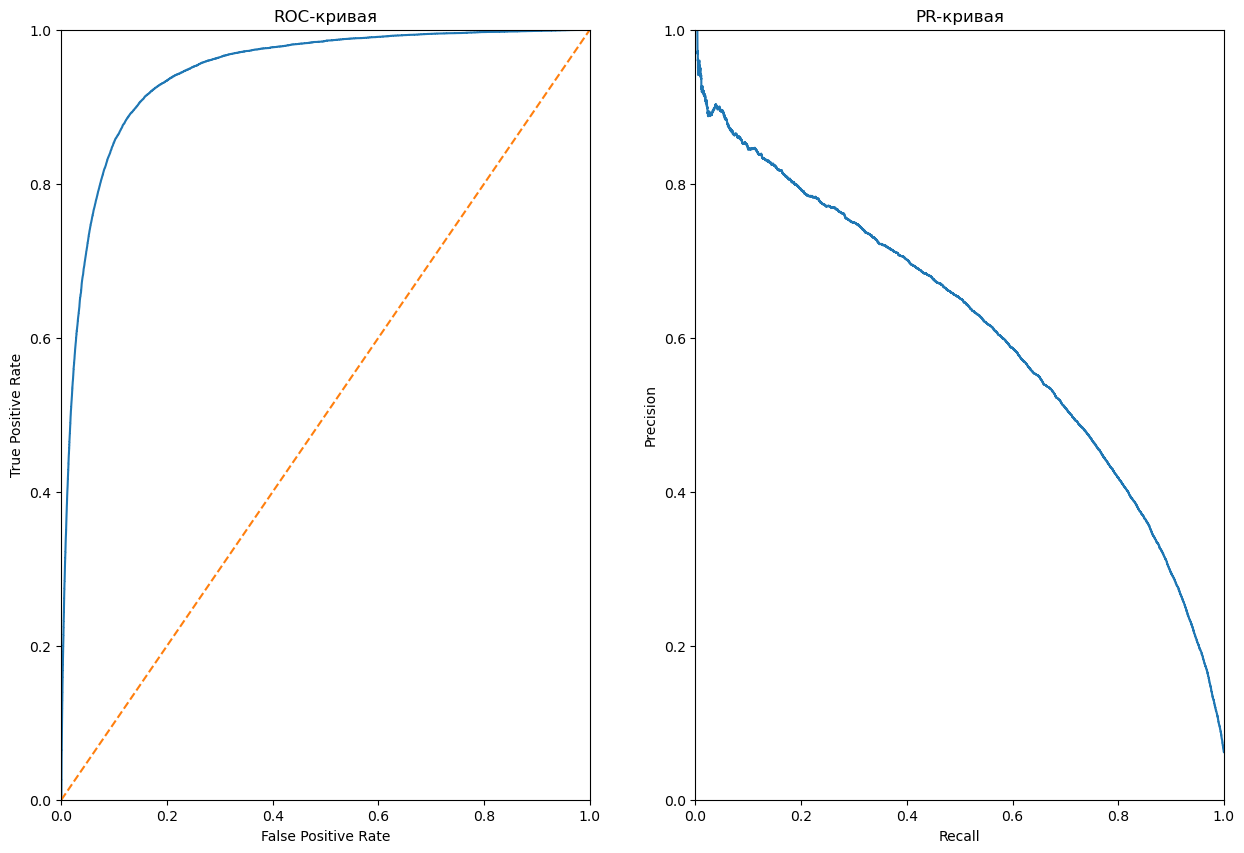

AUROC: 0.94
AUPRC: 0.61


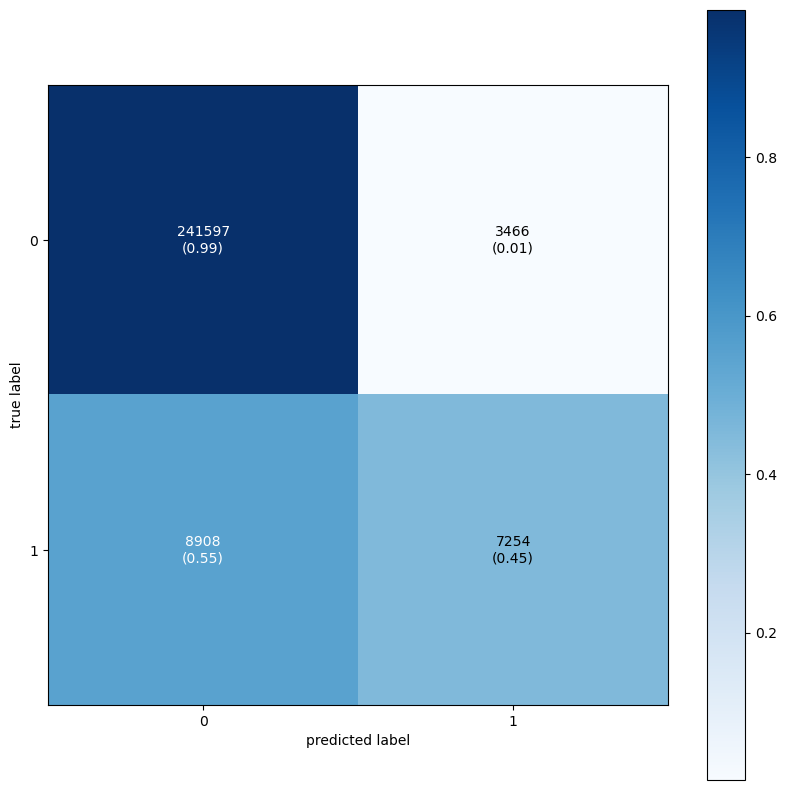

In [138]:
eval_predictions(model_ctb, X_train_vec, y_train, X_test_vec, y_test)